In [1]:
import os
import sys

def Startup_LearningDynamics():
    # Prepare all needed folders to run the learning simulator
    print('Setting up paths for Learning Dynamics ......')
    home_path = os.getcwd() + os.sep  # Home directory
    #home_path = r'D:/Maggioni\ Python/'
    print(f'  Adding necessary folders to {home_path}...')
    sys.path.append(home_path + 'SOD_Evolve/')  # code to run the dynamics for obtaining observation
    sys.path.append(home_path + 'SOD_Learn/')  # code to run the learning routines
    sys.path.append(home_path + 'SOD_Utils/')  # Utility routines shared by both simulators
    sys.path.extend([os.path.join(home_path, 'SOD_Examples'),  # code to generate the examples for specific dynamics
                     os.path.join(home_path, 'SOD_External')])  # external package(s)
    print('done.')
    print(os.getcwd() )

Startup_LearningDynamics()

Setting up paths for Learning Dynamics ......
  Adding necessary folders to C:\Users\CluClu\Downloads\Maggioni Python\...
done.
C:\Users\CluClu\Downloads\Maggioni Python


In [314]:
#os.chdir("D:/Maggioni Python")
print(os.getcwd() )

C:\Users\CluClu\Downloads\Maggioni Python


In [2]:
import numpy as np
#from Predators_Swarm.PS_init_config import PS_init_config



def PredatorPrey1stOrder_def():
    # System
    sys_info = {}
    sys_info['name'] = 'PredatorPrey1stOrder'
    N_preys = 9
    N_predators = 1
    prey_attract_prey = 1
    predator_repulse_prey = 2
    prey_attract_predator = 3.5
    predator_sense_prey = 3
    sys_info['d'] = 2
    sys_info['N'] = N_preys + N_predators
    sys_info['phiE'] = {
        (1, 1): 'lambda r: PS_1st_order_prey_on_prey(r, prey_attract_prey=1)',
        (1, 2): 'lambda r: PS_1st_order_predator_on_prey(r, predator_repulse_prey=2)',
        (2, 1): 'lambda r: PS_1st_order_prey_on_predator(r, prey_attract_predator=3.5, predator_sense_prey=3)',
        (2, 2): 'lambda r: PS_1st_order_predator_on_predator(r)'
    }
    sys_info['K'] = 2
    sys_info['ode_order'] = 1
    sys_info['type_info'] = np.concatenate((np.ones(N_preys), 2 * np.ones(N_predators)))
    sys_info['kappa'] = np.ones(sys_info['K'])
    sys_info['RE'] = None
    sys_info['has_noise'] = False
    sys_info['mu0'] = 'lambda sysa: PS_init_config(sysa["N"], sysa["type_info"], 1)'
    sys_info['T_f'] = 10

    # ODE solver
    solver_info = {}

    solver_info['time_span']= [0, sys_info['T_f']]
    # Observations
    obs_info = {}
    obs_info['L'] = 10
    obs_info['M'] = 5
    #obs_info['M_rhoT'] = 2000
    #Change for testing
    obs_info['M_rhoT'] = 20
    obs_info['T_L'] = sys_info['T_f'] / 2
    obs_info['time_vec'] = np.linspace(0, obs_info['T_L'], obs_info['L'])
    obs_info['use_derivative'] = True
    obs_info['hist_num_bins'] = 50
    obs_info['obs_noise'] = 0.0

    # Learning
    basis_info = {}
    basis_info['n'] = np.maximum(64 * np.ones((sys_info['K'], sys_info['K'])),
                                np.array([[np.ceil(obs_info['L'] * obs_info['M'] * N_preys * sys_info['d'] / 500),
                                           np.ceil(obs_info['L'] * obs_info['M'] * np.sqrt(N_preys * N_predators) *
                                                   sys_info['d'] / 500)],
                                          [np.ceil(obs_info['L'] * obs_info['M'] * np.sqrt(N_preys * N_predators) *
                                                   sys_info['d'] / 500),
                                           np.ceil(obs_info['L'] * obs_info['M'] * N_predators * sys_info['d'] / 500)]]))
    basis_info['type'] = 'standard'
    basis_info['degree'] = np.array([[1, 1], [1, 0]])
    learn_info = {'Ebasis_info': basis_info}

    # package the data
    Example = {}
    Example['sys_info'] = sys_info
    Example['solver_info'] = solver_info
    Example['obs_info'] = obs_info
    Example['learn_info'] = learn_info

    return Example

In [3]:
import os
from pytictoc import TicToc
#import SOD_Utils.Load_Example_Definitions, SOD_Utils.Select_Example, SOD_Utils.restructure_sys_info_for_larger_N, SOD_Utils.computeL2rhoTErr, SOD_Utils.final_visualization
from SOD_Utils.Load_Example_Definitions import LoadExampleDefinitions
from SOD_Utils.Select_Example import SelectExample

from SOD_Learn.generateRhoLT import generateRhoLT
from SOD_Learn.learningRoutine import learningRoutine
from SOD_Learn.estimateTrajAccuracies import estimateTrajAccuracies
from SOD_Utils.computeL2rhoTErr import computeL2rhoTErr
from SOD_Utils.restructure_sys_info_for_larger_N import restructure_sys_info_for_larger_N
from SOD_Utils.final_visualization import final_visualization
def main_example():
    
    # Set parameters
    if os.name == 'nt':
        SAVE_DIR = os.path.join(os.environ['USERPROFILE'], 'DataAnalyses', 'LearningDynamics')
    else:
        SAVE_DIR = os.path.join(os.environ['HOME'], 'DataAnalyses', 'LearningDynamics')

    VERBOSE = 1
    Params = None
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    # Load example definitions and let user select one example to run

    Examples = LoadExampleDefinitions()
    ExampleIdx = SelectExample(Params, Examples)

    # Get example parameters
    Example = Examples[ExampleIdx]
    #print(Example)
    sys_info = Example['sys_info']
    solver_info = Example['solver_info']
    obs_info = Example['obs_info']
    learn_info = Example['learn_info']
    plot_info = Example['plot_info']
    #print(solver_info)
    # Other settings
    reuse_rho_T = False
    n_trials = 1

    learn_info['to_predict_LN'] = True
    learn_info['is_parallel'] = False
    learn_info['keep_obs_data'] = True
    learn_info['VERBOSE'] = VERBOSE
    learn_info['SAVE_DIR'] = SAVE_DIR
    learn_info['MEMORY_LEAN'] = True
    obs_info['compute_pICs'] = False
    obs_info['VERBOSE'] = VERBOSE
    obs_info['SAVE_DIR'] = SAVE_DIR

    # obs_info['obs_noise'] = 0.0
    if obs_info['obs_noise'] > 0:
        obs_info['use_derivative'] = True

    # Start parallel pool
    # gcp()  # Not required in Python

    time_stamp = 'your_date_string'  # Replace with a valid date string

    # Generate rho^L_T if needed
    print('\n================================================================================')
    print('\nGenerating rhoT......')
    tictoc = TicToc()
    tictoc.tic()
    obs_info['rhoLT'] = generateRhoLT(sys_info, solver_info, obs_info, reuse_rho_T)
    tictoc.toc()
    print(f'done ({tictoc.elapsed})')
    #exit
    # Perform learning and test performance on trajectories
    learningOutput = []
    learn_info['sys_info'] = sys_info.copy()
    print('\n================================================================================')
    print('\nLearning Interaction Law(s)......')
    for trial_idx in range(n_trials):
        if VERBOSE >= 1:
            print(f'\n------------------- Learning with trial ID#{trial_idx + 1}.')
        print(learn_info)
        learn_out = learningRoutine(solver_info, obs_info, learn_info)
        learningOutput.append(learn_out)

    # Test the performance on phi_hats (and regularized phi_hats)
    print('\n================================================================================')
    tictoc.tic()
    print('\nComputing L2(rhoT) Errors......')
    rStr = ''
    for k in range(n_trials - 1, -1, -1):
        learningOutput[k]['L2rhoTErr'] = computeL2rhoTErr(learningOutput[k]['Estimator'], sys_info, obs_info)
        msg = f'{k + 1:3d}'
        print(rStr + msg, end='')
        rStr = '\b' * len(msg)
    tictoc.toc()
    print(f'\nOverall time for computing L2(rho_T) errors: {tictoc.elapsed}')

    # Test performance on trajectories
    print('\n================================================================================')
    tictoc.tic()
    print('\nComputing Trajectory Errors......')
    rStr = ''
    #Keep copy of sys_info since we are going to modify.
    sys_info_cp = sys_info.copy()


    if 'to_predict_LN' in learn_info and learn_info['to_predict_LN']:
        obs_info['N_ratio'] = learn_info['N_ratio']
        sys_info_Ntransfer = restructure_sys_info_for_larger_N(learn_info['N_ratio'], sys_info_cp)
    else:
        sys_info_Ntransfer = None

    print('\n------------------- Trajectory Error with trial ID#: ')


    for k in range(n_trials - 1, -1, -1):
        learningOutput[k]['Timings']['estimateTrajAccuracies'] = TicToc()
        learningOutput[k]['Timings']['estimateTrajAccuracies'].tic()
        (
            learningOutput[k]['trajErr'],
            learningOutput[k]['trajErr_new'],
            learningOutput[k]['y_init_new'],
            learningOutput[k]['trajErr_Ntransfer'],
            learningOutput[k]['y_init_Ntransfer'],
            learningOutput[k]['syshatsmooth_info_Ntransfer']
        ) = estimateTrajAccuracies(sys_info, learningOutput[k]['syshatsmooth_info'], learningOutput[k]['obs_data'], obs_info, solver_info, sys_info_Ntransfer)
        learningOutput[k]['Timings']['estimateTrajAccuracies'].toc()
        msg = f'{k + 1:3d}'
        print(rStr + msg, end='')
        rStr = '\b' * len(msg)
    tictoc.toc()
    print(f'\nOverall time for computing trajectory errors: {tictoc.elapsed}')

    # Save
    #plot_info['save_file'] = os.path.join(SAVE_DIR, f'{sys_info["name"]}_learningOutput_{time_stamp}.mat')
    import scipy.io as sio

    """
    sio.savemat(
        plot_info['save_file'],
        {
            'sys_info': sys_info,
            'solver_info': solver_info,
            'obs_info': obs_info,
            'learn_info': learn_info,
            'plot_info': plot_info,
            'learningOutput': learningOutput,
            'sys_info_Ntransfer': sys_info_Ntransfer,
            'time_stamp': time_stamp,
        },
        appendmat=False,
        format='5',
    )
    """

    plot_info_save = {
        'sys_info': sys_info,
        'solver_info': solver_info,
        'obs_info': obs_info,
        'learn_info': learn_info,
        'plot_info': plot_info,
        'learningOutput': learningOutput,
        'sys_info_Ntransfer': sys_info_Ntransfer,
        'time_stamp': time_stamp,
        'appendmat': False,
        'format' : 5
    }

    with open('C:/Users/CluClu/Downloads/Maggioni Python/SOD_Utils/ode_data.txt','w') as data: 
          data.write(str(plot_info_save))
   


    # Display & figures


    # Done
    print('\ndone.')
    #if __name__ == "__main__":
    return learningOutput, obs_info, solver_info, sys_info, sys_info_Ntransfer, learn_info, time_stamp, plot_info

In [4]:
learningOutput, obs_info, solver_info, sys_info, sys_info_Ntransfer, learn_info, time_stamp, plot_info = main_example()

Loaded example 1/3 in  0.000713 seconds.
Loaded example 2/3 in  0.000792 seconds.
Loaded example 3/3 in  0.000393 seconds.

Examples:
 [1] PredatorPrey1stOrderSplines
 [2] PredatorPrey1stOrder
 [3] PredatorPrey2ndOrder


Pick an example to run: 2

Running PredatorPrey1stOrder



Generating rhoT......
None 0.001213 seconds.
(20, 20)
---------------------

Obtained trajectory and derivative in  0.000301 seconds.
Obtained trajectory and derivative in  0.000277 seconds.
Obtained trajectory and derivative in  0.000241 seconds.
Obtained trajectory and derivative in  0.000240 seconds.
Obtained trajectory and derivative in  0.000208 seconds.
Obtained trajectory and derivative in  0.000196 seconds.
Obtained trajectory and derivative in  0.000201 seconds.
Obtained trajectory and derivative in  0.000196 seconds.
Obtained trajectory and derivative in  0.000195 seconds.
Obtained trajectory and derivative in  0.000205 seconds.
Obtained trajectory and derivative in  0.000201 seconds.
Obtained traject

C:\Users\CluClu\Downloads\Maggioni Python\SOD_Learn\package_rhoLT.py:48: RuntimeWarning: invalid value encountered in divide
  hist_R[k1][k2] = histcount_R[k1][k2] / (np.sum(histcount_R[k1][k2]) * histbinwidthR[k1][k2])


Obtained trajectory and derivative in  0.000219 seconds.
None 0.105288 seconds.
None 0.009769 seconds.
From uniform_basis_by_class 

[[8.64746345 8.64746883]
 [8.64746883 8.6474742 ]]
From construct_piecewise_polynomial_basis a,b, n

0 8.647463448839236 64
From construct_piecewise_polynomial_basis a,b, n

0 8.64746882597593 64
From construct_piecewise_polynomial_basis a,b, n

0 8.64746882597593 64
From construct_piecewise_polynomial_basis a,b, n

0 8.647474203112623 64
None 0.000788 seconds.
None 0.000005 seconds.
None 0.002919 seconds.
None 0.018078 seconds.
None 0.000005 seconds.
None 0.003019 seconds.
None 0.015489 seconds.
None 0.000004 seconds.
None 0.002987 seconds.
None 0.020735 seconds.
None 0.000003 seconds.
None 0.002966 seconds.
None 0.021003 seconds.
None 0.000003 seconds.
None 0.003406 seconds.
None 0.017487 seconds.
None 0.000005 seconds.
None 0.002984 seconds.
None 0.014864 seconds.
None 0.000003 seconds.
None 0.002959 seconds.
None 0.017008 seconds.
None 0.000004 second

C:\Users\CluClu\Downloads\Maggioni Python\SOD_Learn\uniform_learn_interactions_on_x_and_v.py:62: RuntimeWarning: divide by zero encountered in divide
  Estimator['Info']['phiCond'] = Estimator['Info']['phiSingVals'][0] / Estimator['Info']['phiSingVals'][-1]
C:\Users\CluClu\Downloads\Maggioni Python\SOD_Learn\uniform_learn_interactions_on_x_and_v.py:62: RuntimeWarning: invalid value encountered in divide
  Estimator['Info']['phiCond'] = Estimator['Info']['phiSingVals'][0] / Estimator['Info']['phiSingVals'][-1]


None 0.037759 seconds.
done (None sec).
The empirical error from learning phis on x/v is: [[116.39889269]].
The empirical error from learning phis on xi is: None.
--------------------------------------------------------------------------------
Regularizing the learned Estimators...


Computing L2(rhoT) Errors......
  1Elapsed time is 0.018528 seconds.

Overall time for computing L2(rho_T) errors: 0.018527900043409318


Computing Trajectory Errors......
restructure_sys_info_for_larger_N: 10

------------------- Trajectory Error with trial ID#: 
Obtained trajectory and derivative in  0.000222 seconds.
Obtained trajectory and derivative in  0.000280 seconds.
Obtained trajectory and derivative in  0.000214 seconds.
Obtained trajectory and derivative in  0.000184 seconds.
Obtained trajectory and derivative in  0.000221 seconds.
Obtained trajectory and derivative in  0.000182 seconds.
Obtained trajectory and derivative in  0.000285 seconds.
Obtained trajectory and derivative in  0.000237 sec

C:\Users\CluClu\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CluClu\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\CluClu\Downloads\Maggioni Python\SOD_Evolve\find_phis_of_pdist.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  phis_of_pdist[np.ix_(row_ind, col_ind)] = phi_of_pdist_Ck1_Ck2 * (kappa[k2-1] / N_k2)
C:\Users\CluClu\Downloads\Maggioni Python\SOD_Utils\state_norm.py:12: RuntimeWarning: invalid value encountered in scalar divide
  state_norm[k] = np.sum(the_sum[C_ks[k, :]]) / N_ks[k]


Obtained trajectory and derivative in  0.000426 seconds.
Obtained trajectory and derivative in  0.000343 seconds.
Obtained trajectory and derivative in  0.000244 seconds.
Obtained trajectory and derivative in  0.000235 seconds.
Obtained trajectory and derivative in  0.000245 seconds.
Obtained trajectory and derivative in  0.000235 seconds.
Obtained trajectory and derivative in  0.000241 seconds.
Obtained trajectory and derivative in  0.000235 seconds.
Obtained trajectory and derivative in  0.000242 seconds.
Obtained trajectory and derivative in  0.000232 seconds.
Obtained trajectory and derivative in  0.000268 seconds.
Obtained trajectory and derivative in  0.000255 seconds.
Obtained trajectory and derivative in  0.000272 seconds.
Obtained trajectory and derivative in  0.000257 seconds.
Obtained trajectory and derivative in  0.000271 seconds.
Obtained trajectory and derivative in  0.000245 seconds.
Obtained trajectory and derivative in  0.000256 seconds.
Obtained trajectory and derivat

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from SOD_Utils.displayTrajErrs import displayTrajerrs
from SOD_Utils.displayLearningResults import  displaylearningresults
from SOD_Utils.visualize_trajs import visualizetrajs
from SOD_Utils.display_L2rhoT_errs import displayL2rhoTerrs

def final_visualization(learning_output, obs_info, solver_info, sys_info, sys_info_Ntransfer, learn_info, time_stamp, plot_info):
    # displaying errors
    print('\n================================================================================')
    print(f'\n------------------- Errors over {len(learning_output)} Learning Trial(s)')
    if 'trajErr' in learning_output[0]:
        displayTrajerrs(learning_output, obs_info, solver_info)  # Implement displayTrajErrs function in Python
    if 'L2rhoTErr' in learning_output[0]:
        displayL2rhoTerrs(learning_output, sys_info)  # Implement displayL2rhoTErrs function in Python

    # displaying results
    print('\n------------------- Visualizing phis and trajs')
    plot_info['solver_info'] = solver_info
    plot_info['for_larger_N'] = False
    displaylearningresults(learning_output, sys_info, learning_output[0]['syshatsmooth_info'], obs_info, learn_info, learning_output[0]['obs_data']['ICs'], plot_info)  # Implement displayLearningResults function in Python

    # for Larger N
    if sys_info_Ntransfer is not None:
        plot_info['for_larger_N'] = True
        sys_info1 = sys_info.copy()
        visualizetrajs(learning_output, sys_info_Ntransfer, learning_output[0]['syshatsmooth_info_Ntransfer'], obs_info, learning_output[0]['y_init_Ntransfer'], plot_info)  # Implement visualize_trajs function in Python
        print("final_visualization - method visualizetrajs")
        sys_info = sys_info1.copy()
    #plt.show(block=True)



------------------- Errors over 1 Learning Trial(s)

------------------- Trajectory accuracies, same IC's as training data:
	sup-norm on [0, 5.0], mean = 1.5285e-04±9.5330e-05, std = 1.5285e-04±9.5330e-05
	sup-norm on [5.0, 10], mean = 1.1086e-04±6.1276e-05, std = 1.1086e-04±6.1276e-05

------------------- Trajectory accuracies, new IC's:
	sup-norm on [0, 5.0], mean = 1.7952e-03±6.3865e-03, std = 1.7952e-03±6.3865e-03
	sup-norm on [5.0, 10], mean = 6.6202e-04±1.6802e-03, std = 6.6202e-04±1.6802e-03

------------------- Visualizing phis and trajs


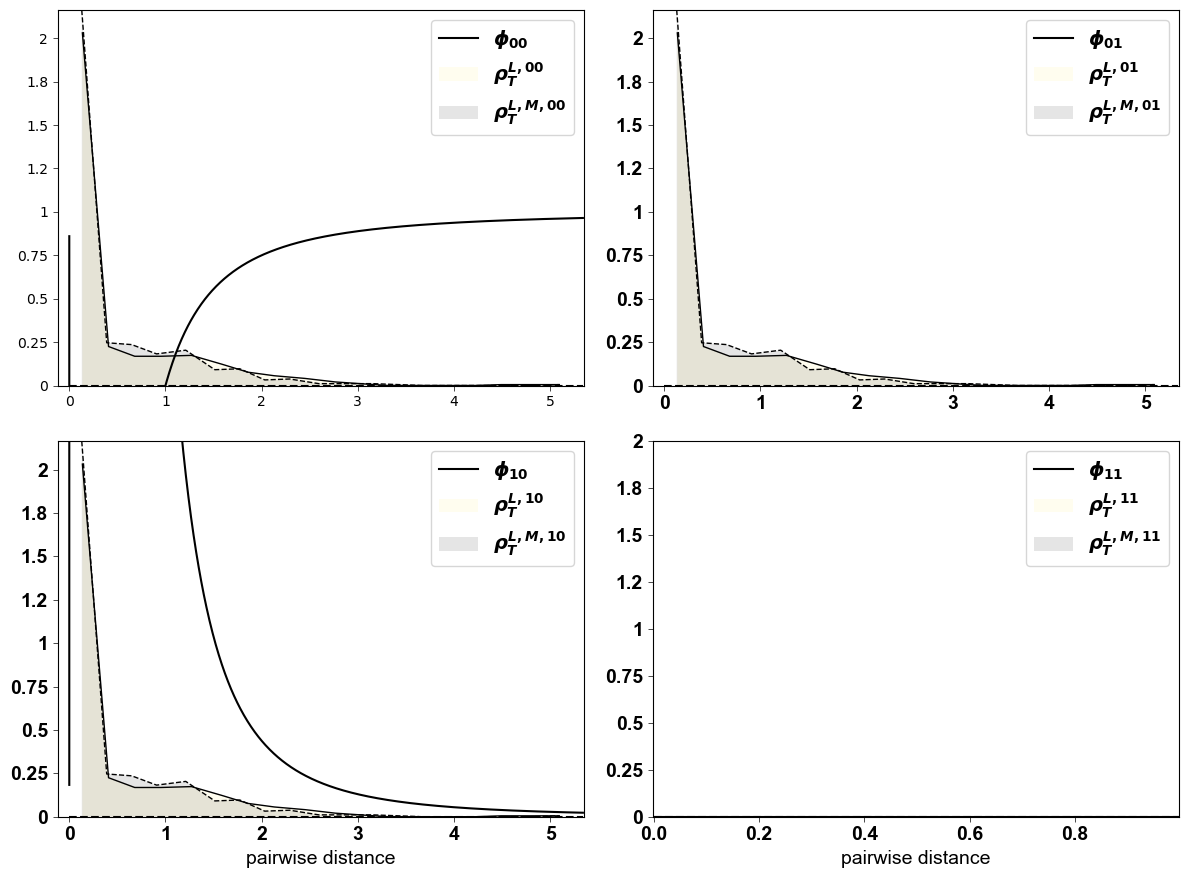



------------------- Trajectory Error over One Initial Condition

Traj. Err. with an initial condition taken from training data:

  sup-norm on [0.0000e+00,5.0000e+00] = 2.1463e-04.
  sup-norm on [5.0000e+00,1.0000e+01] = 1.2013e-04.

Traj. Err. with another initial condition randomly chosen:

  sup-norm on [0.0000e+00,5.0000e+00] = 3.2988e-03.
  sup-norm on [5.0000e+00,1.0000e+01] = 1.4936e-03.


KeyError: 'plot_name'

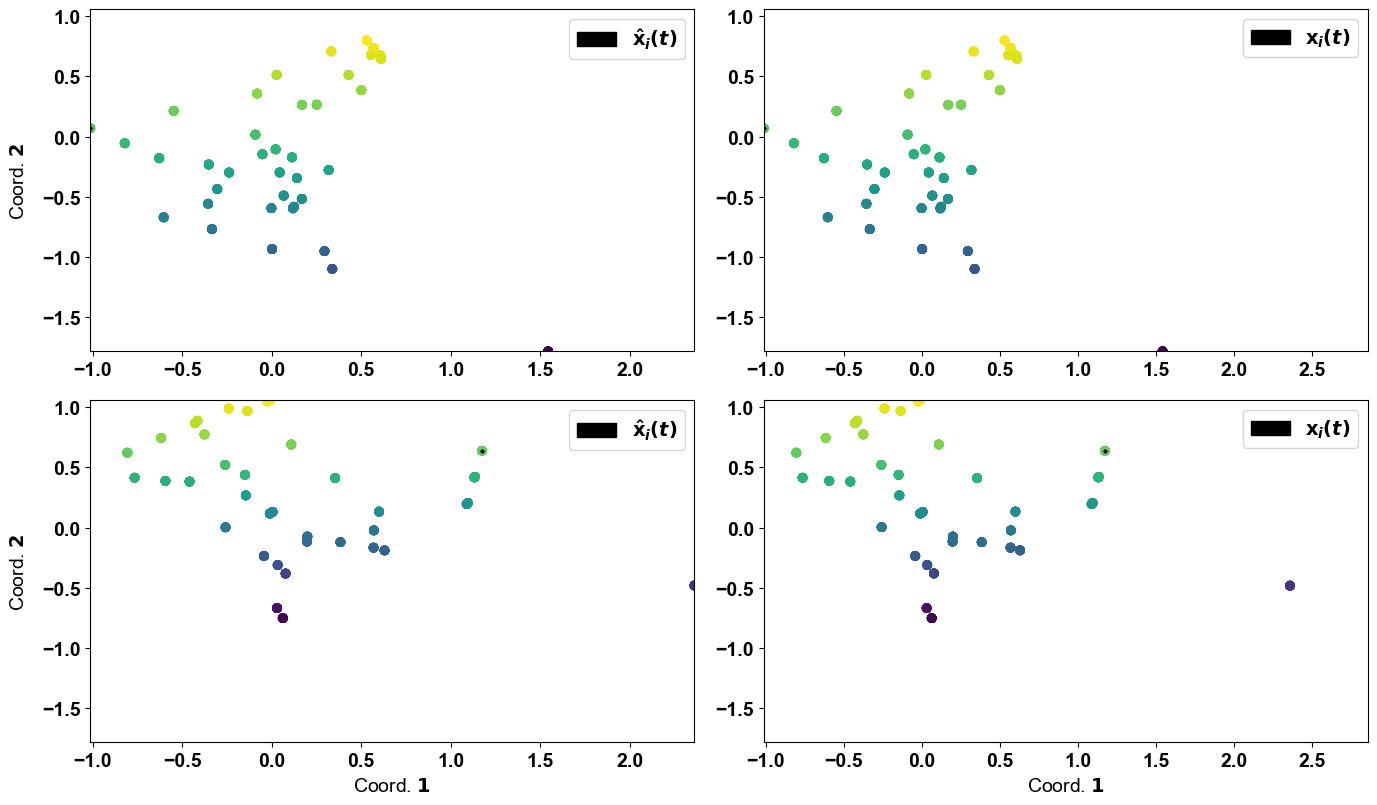

In [6]:
final_visualization(learningOutput, obs_info, solver_info, sys_info, sys_info_Ntransfer, learn_info, time_stamp, plot_info)

In [180]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import ode
from SOD_Evolve.eval_rhs import eval_rhs

def self_organized_dynamics_new(y_init, sys_info, solver_info):
    """
    Runs a self-organized dynamics of the given form

    Args:
    y_init: Initial condition to run the dynamics
    sys_info: Information regarding the system of the dynamics
    solver_info: Information regarding the setup of the numerical integrator

    Returns:
    dynamics: Structure with `x` and `y` fields representing times and solution values, respectively.
    flag: 0 if integration was successful up to time `solver_info['time_span'][-1]`, 1 otherwise.

    """
    #Normalize the data to avoid dividing zero error
    #med = np.median(y_init[y_init > 0]) #Normalize the initial value if there is any zero.
    #y_init[y_init == 0] = med
    
    # Stochastic dynamics not supported yet
    #print('I am in ode.....\n')
    #print(y_init)
    if sys_info['has_noise']:
        raise NotImplementedError('Stochastic Interaction is not implemented yet!!')
    
    t0 = solver_info['time_span'][0]
    #dynamics = ode(f, jac=None).set_integrator('zvode', method='bdf', with_jacobian=True)
    #vode',method='adams'

    dynamics = ode(f, jac=None).set_integrator('zvode',method='bdf', atol=10**-6, rtol=10**-6,nsteps=1e8)
    
   
    dynamics.set_initial_value(y_init,t0 ).set_f_params(sys_info,)

    tf = solver_info['time_span'][1]   #Final time
    dt = 1.0e-7
    #dt = 0.5

    #tv = np.arange(0,10,0.1)   # Times to evaluate a solution. 
    tv = np.linspace(t0,tf,50)
    #tv =np.linspace(0,30,111)
    yf = []
    tf = []
    tv1 = tv[1:]
    #yf = np.zeros((20,2))

    yf = y_init.reshape((-1,1))
    #print(yf)

    for i in range(len(tv[1:])):
        dynamics.integrate(dynamics.t+dt)
        if not (dynamics.successful()):
            print('Integration not successful!!')
            break
        arr1 = dynamics.y
        arr1 = np.array(arr1)
        arr1 = arr1.reshape((-1,1))
        #print(arr1)
        yf = np.hstack((yf,arr1))
        tf.append(dynamics.t)

    yf = yf[:,1:]
    #print(yf)
    if dynamics.t < solver_info['time_span'][1]:
        flag = False
        stats = {'nfailed':1}
    else:
        flag = True   #Bad data
        stats = {'nfailed':-1}

    
    dynamics.stats = stats

    yR = np.real(yf)
    dynamics.x = yR
   
    dynamics.flag = flag


    dynamics.tm = tf
    #Time interval
    dynamics.tv = tv[1:]

    
    return dynamics

def f(t, y, sys_info):
    """
    Nested function to evaluate the right-hand side of the ODE system

    Args:
    t: Current time
    y: Current solution
    sys_info: System information dictionary

    Returns:
    rhs: Right-hand side of the ODE system

    """
    # Extract relevant variables from y
    #print('From odefun \n')
    #print(y)
    #print('\n')
    rhs = eval_rhs(y, sys_info)
   
    return rhs

In [181]:
import numpy as np
#learning_output, sys_info, learning_output[0]['syshatsmooth_info'], obs_info, learn_info, learning_output[0]['obs_data']['ICs'], plot_info
learning_output = learningOutput
syshat_info= learning_output[0]['syshatsmooth_info']
syshat_info
obs_info
ICs=learning_output[0]['obs_data']['ICs']
np.set_printoptions(threshold=sys.maxsize)
#ICs.sort()
ICs[:,0]

array([-1.205795  , -1.27027522, -1.09151345, -1.10973222, -1.26658834,
       -1.17316552, -1.02181133, -1.21288015, -1.23602646, -0.07351251,
       -1.18306903, -1.21813241, -1.02625446, -1.15221514, -1.01305076,
       -1.1956139 , -1.06761921, -1.03961464, -0.84524463, -0.08982083])

In [164]:
y_init


array([-1.205795  , -1.27027522, -1.09151345, -1.10973222, -1.26658834,
       -1.17316552, -1.02181133, -1.21288015, -1.23602646, -0.07351251,
       -1.18306903, -1.21813241, -1.02625446, -1.15221514, -1.01305076,
       -1.1956139 , -1.06761921, -1.03961464, -0.84524463, -0.08982083])

In [182]:
import numpy as np
from SOD_Evolve.self_organized_dynamics import self_organized_dynamics
from SOD_Utils.insert_time_vec import insert_time_vec
from SOD_Utils.traj_norm import traj_norm
from SOD_Utils.deval_dynamics import deval_dynamics


result = {}
for m in range(ICs.shape[1]):
    y_init = ICs[:, m]
    #dynamics = self_organized_dynamics_new(y_init, sys_info, solver_info)
    dynamicshat = self_organized_dynamics_new(y_init, syshat_info, solver_info)
    if not dynamics.flag and not dynamicshat.flag:
        break

#dynamicshat.x
#np.histogram(dynamics.x[3],bins=100)

In [202]:
X_c1s, X_c2s = [None] * 4, [None] * 4
x_min, x_max = np.zeros(4), np.zeros(4)
y_min, y_max = np.zeros(4), np.zeros(4)
traj = dynamicshat.x
end1 = traj.shape[0]
#print(traj[0:end1 -1:2,:].shape)
X_c1, X_c2 = traj[0:end1 -1:2, :], traj[1:end1:2, :]
X_c1s[ind] = X_c1
X_c2s[ind] = X_c2
x_min[ind]      = min(X_c1.ravel())
x_max[ind]      = max(X_c1.ravel())
y_min[ind]      = min(X_c2.ravel())
y_max[ind]      = max(X_c2.ravel())

In [231]:
y_min, y_max

(-1.2702750782031598, 0.0)

In [236]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


x_min = np.min(x_min)
x_max = np.max(x_max)
y_min = np.min(y_min)
y_max = np.max(y_max)

#T_loc = np.where(time_vec == obs_info['T_L'])[0][0]
polygon = []
for ind in range(1):
    #plt.subplots(2, 2)
    row_ind = ind // 2
    col_ind = ind % 2
    #ax = axes[row_ind, col_ind]
    #ax.set_xlim([x_min - 0.5, x_max+0.5])
    #ax.set_ylim([y_min - 0.5, y_max + 0.5])
   
    X_c1, X_c2 = X_c1s[ind], X_c2s[ind]
    c2_at_t = []
    c1_at_t = []
  
    for k in range(sys_info['K']):
        agents_Ck = np.where(np.array(sys_info['type_info']) == k+1)[0]
        N_k = len(agents_Ck)
        #plot = ax.scatter([], [])
        for agent_ind in range(N_k):
            agent = agents_Ck[agent_ind]
            c1_at_t.append(X_c1[agent, :])
            c2_at_t.append(X_c2[agent, :])
            #polygon.append(Polygon(np.column_stack((X_c1[agent, :],X_c2[agent, :]))))
            
            

In [247]:
c2_at_t = np.array(c2_at_t)
c1_at_t = np.array(c1_at_t)
c1_at_t[0]

array([-1.20579483, -1.20579465, -1.20579448, -1.20579431, -1.20579414,
       -1.20579397, -1.20579379, -1.20579362, -1.20579345, -1.20579328,
       -1.20579311, -1.20579293, -1.20579276, -1.20579259, -1.20579242,
       -1.20579225, -1.20579208, -1.2057919 , -1.20579173, -1.20579156,
       -1.20579139, -1.20579122, -1.20579104, -1.20579087, -1.2057907 ,
       -1.20579053, -1.20579036, -1.20579018, -1.20579001, -1.20578984,
       -1.20578967, -1.2057895 , -1.20578932, -1.20578915, -1.20578898,
       -1.20578881, -1.20578864, -1.20578846, -1.20578829, -1.20578812,
       -1.20578795, -1.20578778, -1.20578761, -1.20578743, -1.20578726,
       -1.20578709, -1.20578692, -1.20578675, -1.20578657])

In [242]:
c2_at_t = np.array(c2_at_t)
c_vecs = np.round(c2_at_t.mean(axis = 1), decimals = 4)
cmap = plt.cm.viridis
polygons = [Polygon(np.column_stack((x_row,y_row))) for x_row, y_row in zip(c1_at_t,c2_at_t)]
collection = PatchCollection(polygons, cmap = cmap, alpha = 0.5)
collection.set_array(c_vecs[k])
collection.set_cmap(cmap)
fig, ax = plt.subplots()
ax.add_collection(collection)

ax.scatter(c1_at_t,c2_at_t)
#get_colored_line(c1_at_t, c2_at_t, c_vecs[k],ax)
#ax.scatter(X_c1[:, T_loc], X_c2[:, T_loc], s=plot_info['T_L_marker_size'], c='k', marker='o')

ax.set_xlim([x_min-0.5, x_max+0.5])
ax.set_ylim([y_min - 0.5, y_max+0.5])
plt.show()
   

SystemError: <built-in method draw_path_collection of matplotlib.backends._backend_agg.RendererAgg object at 0x000001C40E842D90> returned a result with an exception set

<Figure size 640x480 with 1 Axes>

In [238]:
c2_at_t

[array([-1.27027508, -1.27027494, -1.27027479, -1.27027465, -1.27027451,
        -1.27027437, -1.27027422, -1.27027408, -1.27027394, -1.2702738 ,
        -1.27027365, -1.27027351, -1.27027337, -1.27027323, -1.27027308,
        -1.27027294, -1.2702728 , -1.27027266, -1.27027251, -1.27027237,
        -1.27027223, -1.27027209, -1.27027194, -1.2702718 , -1.27027166,
        -1.27027152, -1.27027137, -1.27027123, -1.27027109, -1.27027095,
        -1.2702708 , -1.27027066, -1.27027052, -1.27027038, -1.27027023,
        -1.27027009, -1.27026995, -1.27026981, -1.27026966, -1.27026952,
        -1.27026938, -1.27026924, -1.27026909, -1.27026895, -1.27026881,
        -1.27026867, -1.27026852, -1.27026838, -1.27026824]),
 array([-1.1097321 , -1.10973197, -1.10973184, -1.10973171, -1.10973158,
        -1.10973146, -1.10973133, -1.1097312 , -1.10973107, -1.10973094,
        -1.10973082, -1.10973069, -1.10973056, -1.10973043, -1.1097303 ,
        -1.10973018, -1.10973005, -1.10972992, -1.10972979, -1

In [160]:
time_vec = np.arange(obs_info['time_vec'][0], solver_info['time_span'][1], obs_info['time_vec'][1] - obs_info['time_vec'][0])
time_vec = insert_time_vec(time_vec, obs_info['T_L'])
traj, dtraj = np.array(deval_dynamics(dynamics, time_vec))
trajhat, dtrajhat = np.array(deval_dynamics(dynamicshat, time_vec))

result['traj_true'] = traj[:sys_info['d'] * sys_info['N'], :]
result['traj_hat'] = trajhat[:sys_info['d'] * sys_info['N'], :]
result['time_vec'] = time_vec

# Compute the trajectory error from observed time instances
time_vec = obs_info['time_vec']
traj, dtraj = deval_dynamics(dynamics, time_vec)
trajhat, dtrajhat = deval_dynamics(dynamicshat, time_vec)
result['trajErr'] = traj_norm(traj, trajhat, 'Time-Maxed', sys_info)

# Compare the prediction time interval [T_L, T_f]
time_vec = np.arange(obs_info['T_L'], solver_info['time_span'][1], obs_info['time_vec'][2] - obs_info['time_vec'][0])
traj, dtraj = np.array(deval_dynamics(dynamics, time_vec))
trajhat, dtrajhat = np.array(deval_dynamics(dynamicshat, time_vec))
result['trajErrfut'] = traj_norm(traj, trajhat, 'Time-Maxed', sys_info)

result['m'] = m
result['dynamics'] = dynamics
result['dynamicshat'] = dynamicshat

#return result

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from SOD_Utils.get_colored_line import get_colored_line
from SOD_Utils.construct_color_items import construct_color_items

#def visualize_traj_2D(trajs, time_vec, sys_info, obs_info, plot_info):
if sys_info['d'] != 2:
    raise ValueError('This routine is for 2D Visualization!!')

# Prepare the window size
if 'scrsz' in plot_info and plot_info['scrsz'] is not None:
    scrsz = plot_info['scrsz']
else:
    scrsz = plt.gcf().get_size_inches() * plt.gcf().dpi

# Prepare the figure window
if 'for_larger_N' in plot_info and plot_info['for_larger_N']:
    traj_fig, axes = plt.subplots(2, 2, figsize=(14,9))
else:
    traj_fig, axes = plt.subplots(2, 2, figsize=(14,9))

#Construct color items
if plot_info['for_PNAS']:
    color_output = construct_color_items(sys_info['K'], obs_info['T_L'], plot_info['coarse_time_vec'])
else:
    color_output = construct_color_items(sys_info['K'], obs_info['T_L'], time_vec)

cmap = color_output['cmap']
#c_vecs = plot_info.get('c_vecs', np.linspace(0, 1, sys_info['K']))
c_vecs = color_output['c_vecs']
clabels = color_output['clabels']
cticks = color_output['cticks']

# Split the trajectories
X_c1s, X_c2s = [], []
x_min, x_max = np.zeros(4), np.zeros(4)
y_min, y_max = np.zeros(4), np.zeros(4)

for ind, traj in enumerate(trajs):
    #traj = traj.transpose((2,0,1))
    #traj = traj.reshape(traj.shape[0],(traj.shape[1]*traj.shape[2]))
    end1 = traj.shape[0]
    X_c1, X_c2 = traj[0:end1 -1:2, :], traj[1:end1:2, :]
    X_c1s.append(X_c1)
    X_c2s.append(X_c2)
    x_min[ind]      = min(X_c1.ravel())
    x_max[ind]      = max(X_c1.ravel())
    y_min[ind]      = min(X_c2.ravel())
    y_max[ind]      = max(X_c2.ravel())


x_min = np.min(x_min)
x_max = np.max(x_max)
y_min = np.min(y_min)
y_max = np.max(y_max)

T_loc = np.where(time_vec == obs_info['T_L'])[0][0]

for ind in range(4):
    #plt.subplots(2, 2)
    row_ind = ind // 2
    col_ind = ind % 2
    ax = axes[row_ind, col_ind]

    X_c1, X_c2 = X_c1s[ind], X_c2s[ind]

    for k in range(sys_info['K']):
        agents_Ck = np.where(np.array(sys_info['type_info']) == k+1)[0]
        N_k = len(agents_Ck)

        for agent_ind in range(N_k):
            agent = agents_Ck[agent_ind]
            c1_at_t = X_c1[agent, :]
            c2_at_t = X_c2[agent, :]

            #p_handle = ax.plot(c1_at_t, c2_at_t, linewidth=plot_info['traj_line_width'], 
             #                 linestyle=plot_info['line_styles'][0])
            #color=c_vecs[k]
            #Call function to patch
            p_handle = get_colored_line(c1_at_t, c2_at_t, c_vecs[k],ax)

            #if k == 0 and agent_ind == 0:
             #   ax.hold(True)

    ax.scatter(X_c1[:, T_loc], X_c2[:, T_loc], s=plot_info['T_L_marker_size'], c='k', marker='o')

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

    ax.tick_params(axis='both', which='major', labelsize=plot_info['tick_font_size'])

    if ind == 0:
        xticks = ax.get_xticks()
        delta = xticks[1] - xticks[0]
    elif ind % 2 == 1:
        ax.set_xlim([x_min, x_max + delta])

    if ind % 2 == 0:
        ax.set_ylabel(r'Coord. $2$', fontsize=plot_info['axis_font_size'], fontname=plot_info['axis_font_name'], labelpad=10)

    if ind == 2 or ind == 3:
        ax.set_xlabel(r'Coord. $1$', fontsize=plot_info['axis_font_size'], fontname=plot_info['axis_font_name'], labelpad=5)

    if 'for_PNAS' in plot_info and plot_info['for_PNAS']:
        # The PNAS specific settings
        dyn_markers = plot_info['dyn_markers'][ind]
        m_C1, m_C2 = dyn_markers[::2, :], dyn_markers[1::2, :]

        for k in range(sys_info['K']):
            agents_Ck = np.where(sys_info['type_info'] == k)[0]
            N_k = len(agents_Ck)

            for agent_ind in range(N_k):
                agent = agents_Ck[agent_ind]
                mC1_at_t = m_C1[agent, :]
                mC2_at_t = m_C2[agent, :]
                ax.scatter(mC1_at_t, mC2_at_t, s=plot_info['marker_size'], c=c_vecs[k], marker=plot_info['marker_style'][k])

    leg_name = r'$\mathbf{x}_i(t)$' if ind % 2 == 1 else r'$\hat\mathbf{x}_i(t)$'
    leg_handle = ax.legend([Patch(color='k', linestyle=plot_info['line_styles'][0])], [leg_name],
                           loc=plot_info.get('leg_loc', 'best'), fontsize=plot_info['legend_font_size'])

    #cmap = plt.get_cmap(cmap)
    #if ind % 2 == 1:
        #cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, ticks=cticks)
        #cbar.set_ticklabels(clabels)

#for ax in axes.ravel():
#    ax.get_figure().tight_layout(rect=[0, 0.03, 1, 0.95])
traj_fig.tight_layout()

if 'for_larger_N' in plot_info and plot_info['for_larger_N']:
    plt.savefig(f"{plot_info['plot_name']}_traj_LN")
else:
    plt.savefig(f"{plot_info['plot_name']}_traj")

plt.show()
#plt.ion()
#plt.show(block = False)

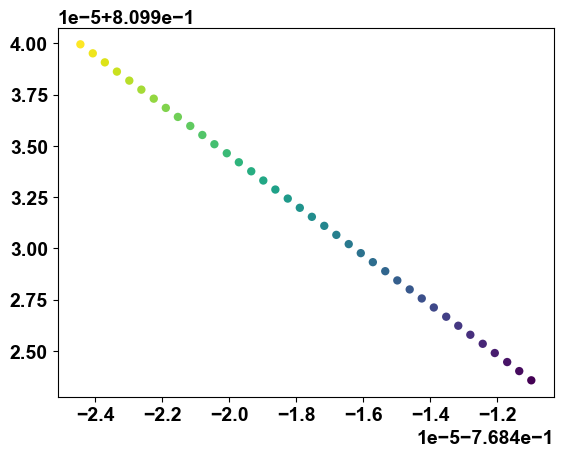

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
def colored_line(x, y, c):
    N = 501
    
    xx = np.linspace(x.min(), x.max(), N)
    yy = np.interp(xx, x, y)
    cc = np.interp(xx, x, c)
    
    ax = plt.gca()
    
    points = np.array([xx, yy]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(yy.min(), yy.max())
    #lc = LineCollection(segments, cmap='viridis', norm=norm)
    #lc.set_array(cc)
    #line = ax.add_collection(lc)
    
    dots = ax.scatter(x, y, c=y, linewidths=0.001)
    return  dots


x = np.linspace(1, 10, 15)
y = np.sin(x)
line = colored_line(z, w, m)
#plt.colorbar(line)

In [132]:
z = np.array([-0.76841098, -0.76841134, -0.7684117 , -0.76841207, -0.76841243,
       -0.7684128 , -0.76841316, -0.76841352, -0.76841389, -0.76841425,
       -0.76841461, -0.76841498, -0.76841534, -0.76841571, -0.76841607,
       -0.76841643, -0.7684168 , -0.76841716, -0.76841753, -0.76841789,
       -0.76841825, -0.76841862, -0.76841898, -0.76841934, -0.76841971,
       -0.76842007, -0.76842044, -0.7684208 , -0.76842116, -0.76842153,
       -0.76842189, -0.76842225, -0.76842262, -0.76842298, -0.76842335,
       -0.76842371, -0.76842407, -0.76842444])
z 

array([-0.76841098, -0.76841134, -0.7684117 , -0.76841207, -0.76841243,
       -0.7684128 , -0.76841316, -0.76841352, -0.76841389, -0.76841425,
       -0.76841461, -0.76841498, -0.76841534, -0.76841571, -0.76841607,
       -0.76841643, -0.7684168 , -0.76841716, -0.76841753, -0.76841789,
       -0.76841825, -0.76841862, -0.76841898, -0.76841934, -0.76841971,
       -0.76842007, -0.76842044, -0.7684208 , -0.76842116, -0.76842153,
       -0.76842189, -0.76842225, -0.76842262, -0.76842298, -0.76842335,
       -0.76842371, -0.76842407, -0.76842444])

In [133]:
w=np.array([0.80992357, 0.80992402, 0.80992446, 0.8099249 , 0.80992535,
       0.80992579, 0.80992623, 0.80992667, 0.80992712, 0.80992756,
       0.809928  , 0.80992844, 0.80992889, 0.80992933, 0.80992977,
       0.80993021, 0.80993066, 0.8099311 , 0.80993154, 0.80993198,
       0.80993243, 0.80993287, 0.80993331, 0.80993376, 0.8099342 ,
       0.80993464, 0.80993508, 0.80993553, 0.80993597, 0.80993641,
       0.80993685, 0.8099373 , 0.80993774, 0.80993818, 0.80993862,
       0.80993907, 0.80993951, 0.80993995])
w

array([0.80992357, 0.80992402, 0.80992446, 0.8099249 , 0.80992535,
       0.80992579, 0.80992623, 0.80992667, 0.80992712, 0.80992756,
       0.809928  , 0.80992844, 0.80992889, 0.80992933, 0.80992977,
       0.80993021, 0.80993066, 0.8099311 , 0.80993154, 0.80993198,
       0.80993243, 0.80993287, 0.80993331, 0.80993376, 0.8099342 ,
       0.80993464, 0.80993508, 0.80993553, 0.80993597, 0.80993641,
       0.80993685, 0.8099373 , 0.80993774, 0.80993818, 0.80993862,
       0.80993907, 0.80993951, 0.80993995])

In [134]:
m=np.array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
       1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
       2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
       3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ,
       5.26315789, 5.52631579, 5.78947368, 6.05263158, 6.31578947,
       6.57894737, 6.84210526, 7.10526316, 7.36842105, 7.63157895,
       7.89473684, 8.15789474, 8.42105263, 8.68421053, 8.94736842,
       9.21052632, 9.47368421, 9.73684211])
m

array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
       1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
       2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
       3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ,
       5.26315789, 5.52631579, 5.78947368, 6.05263158, 6.31578947,
       6.57894737, 6.84210526, 7.10526316, 7.36842105, 7.63157895,
       7.89473684, 8.15789474, 8.42105263, 8.68421053, 8.94736842,
       9.21052632, 9.47368421, 9.73684211])

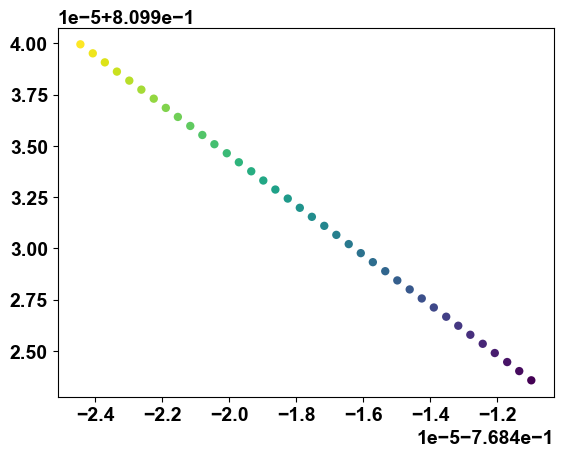

In [149]:
line = colored_line(z, w, m)

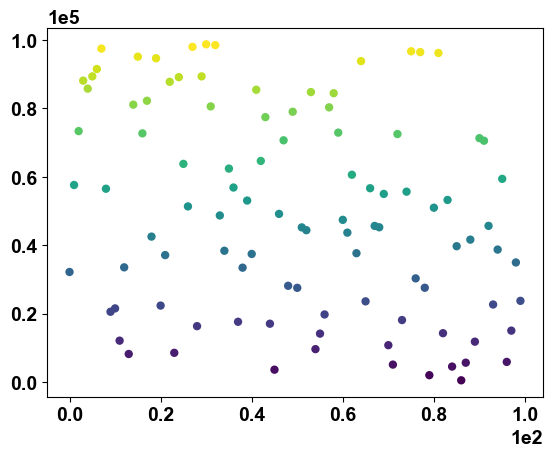

In [148]:
ax = plt.gca()
ax.ticklabel_format(axis='y',style='sci', scilimits=[0,0])
ax.ticklabel_format(axis='x',style='sci' ,scilimits=[0, 0])
ax.scatter(x, y, c=y, linewidths=0.001)

In [161]:
a = np.array([[1,4,0], [5,3,1]])

In [162]:
a

array([[1, 4, 0],
       [5, 3, 1]])

In [167]:
a.sort(key=abs)

TypeError: sort() got an unexpected keyword argument 'key'

In [160]:
a

array([[0, 1, 4],
       [1, 3, 5]])

In [212]:
original = [-2, 1, 4, -5]
original.flip()

AttributeError: 'list' object has no attribute 'flip'

In [169]:
original

[1, -2, 4, -5]

In [177]:
A=[[3,6,2,8],[-1,-6,-3,-8]]
A

[[3, 6, 2, 8], [-1, -6, -3, -8]]

In [178]:
[i.sort(key=abs) for i in A]
A

[[2, 3, 6, 8], [-1, -3, -6, -8]]

In [217]:
centers =np.array([0.0447519 , 0.13425571, 0.22375951, 0.32445129, 0.42514307,
       0.51464687, 0.60415068, 0.70484246, 0.80553424, 0.89503804,
       0.98454185, 1.08523363, 1.18592541, 1.27542921, 1.36493301,
       1.46562479, 1.56631657, 1.65582038, 1.74532418, 1.84601596,
       1.94670774, 2.03621155, 2.13690333])

In [218]:
histdata1 = np.array([0.        , 0.        , 0.01551765, 0.01551765, 0.01551765,
       0.06207061, 0.01551765, 0.04655296, 0.01551765, 0.01551765,
       0.06207061, 0.06207061, 0.06207061, 0.07758826, 0.0310353 ,
       0.12414122, 0.06207061, 0.0310353 , 0.        , 0.13965887,
       0.14896946, 0.18853947, 9.57594306])
#histdata1 = np.sort( histdata1)
histdata1

array([0.        , 0.        , 0.01551765, 0.01551765, 0.01551765,
       0.06207061, 0.01551765, 0.04655296, 0.01551765, 0.01551765,
       0.06207061, 0.06207061, 0.06207061, 0.07758826, 0.0310353 ,
       0.12414122, 0.06207061, 0.0310353 , 0.        , 0.13965887,
       0.14896946, 0.18853947, 9.57594306])

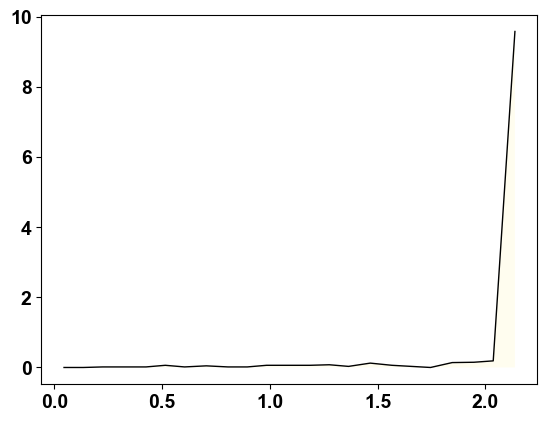

In [219]:
import matplotlib.pyplot as plt
plt.plot(centers, histdata1, 'k', linewidth=1)
plt.fill_between(centers, 0, histdata1, facecolor='lemonchiffon', edgecolor='none', alpha=0.3)
plt.show(block = False)

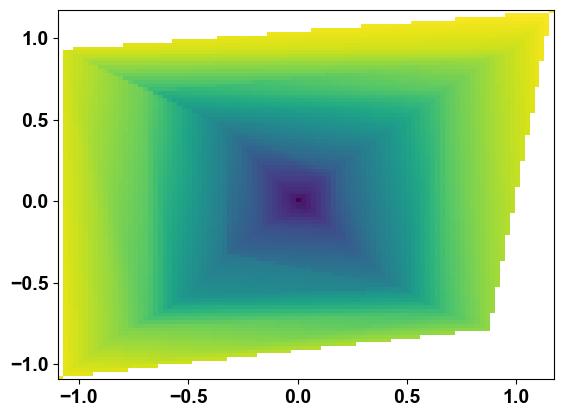

In [266]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)

zi = griddata((x, y), v, (xi[None,:], yi[:,None]), method='linear')

plt.pcolormesh(xi,yi,zi)

plt.show()

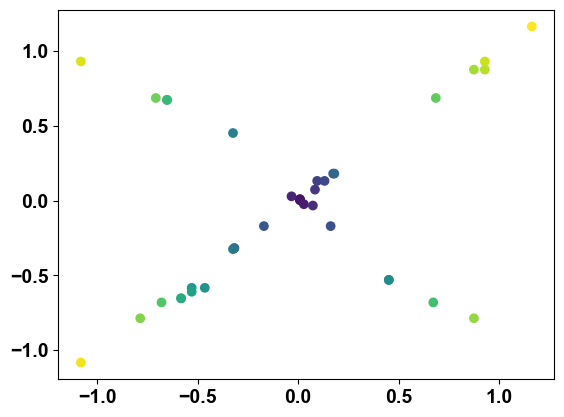

In [265]:
plt.scatter(x,y,c=v)

In [267]:
t_list=np.arange(0,100,5)
t_list

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])

In [269]:
tv = np.linspace(0,10,111) 
tv

array([ 0.        ,  0.09090909,  0.18181818,  0.27272727,  0.36363636,
        0.45454545,  0.54545455,  0.63636364,  0.72727273,  0.81818182,
        0.90909091,  1.        ,  1.09090909,  1.18181818,  1.27272727,
        1.36363636,  1.45454545,  1.54545455,  1.63636364,  1.72727273,
        1.81818182,  1.90909091,  2.        ,  2.09090909,  2.18181818,
        2.27272727,  2.36363636,  2.45454545,  2.54545455,  2.63636364,
        2.72727273,  2.81818182,  2.90909091,  3.        ,  3.09090909,
        3.18181818,  3.27272727,  3.36363636,  3.45454545,  3.54545455,
        3.63636364,  3.72727273,  3.81818182,  3.90909091,  4.        ,
        4.09090909,  4.18181818,  4.27272727,  4.36363636,  4.45454545,
        4.54545455,  4.63636364,  4.72727273,  4.81818182,  4.90909091,
        5.        ,  5.09090909,  5.18181818,  5.27272727,  5.36363636,
        5.45454545,  5.54545455,  5.63636364,  5.72727273,  5.81818182,
        5.90909091,  6.        ,  6.09090909,  6.18181818,  6.27

In [285]:
tv = np.arange(0,200,2)
tv.shape

(100,)

In [286]:
tv[1:]


array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102, 104,
       106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130,
       132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156,
       158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182,
       184, 186, 188, 190, 192, 194, 196, 198])

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

h_bar=0.658212      #reduced Planck's constant (meV*ps)
m0=0.00568563       #free electron mass (meV*ps**2/nm**2)
m_e=0.067*m0        #effective electron mass (meV*ps**2/nm**2)
m_h=0.45*m0         #effective hole mass (meV*ps**2/nm**2)
m_reduced=1/((1/m_e)+(1/m_h)) #reduced mass of electron and holes combined
kB=0.08617          #Boltzmann's constant (meV/K)
mu_e=-50            #initial chemical potential for electrons
mu_h=-100           #initial chemical potential for holes
k_array=np.arange(0,1.5,0.02) #a list of different k-values
n_k=len(k_array) #number of k-values

def derivative(t,y_list,Gamma,g,kappa,k_list,n_k):
    #initialize output vector
    y_out=np.zeros(3*n_k+1,dtype=complex)

    y_out[0:n_k]=-g*g*2*np.real(y_list[2*n_k:3*n_k])/h_bar

    y_out[n_k:2*n_k]=-g*g*2*np.real(y_list[2*n_k:3*n_k])/h_bar  
    y_out[2*n_k:3*n_k]=((-1.j*(k_list**2/(2*m_reduced))-(Gamma+kappa))*y_list[2*n_k:3*n_k]-y_list[-1]*(1-y_list[n_k:2*n_k]-y_list[0:n_k])+y_list[0:n_k]*y_list[n_k:2*n_k])/h_bar

    y_out[-1]=(2*np.real(g*g*sum(y_list[2*n_k:3*n_k]))-2*kappa*y_list[-1])/h_bar
    return y_out

def dynamics(t_list,N_ini=1e-3, T=300, Gamma=1.36,kappa=0.02,g=0.095):

    #initial values
    t0=0 #initial time
    y_initial=np.zeros(3*n_k+1,dtype=complex)
    y_initial[0:n_k]=1/(1+np.exp(((h_bar*k_array)**2/(2*m_e)-mu_e)/(kB*T))) #Fermi-Dirac distributions
    y_initial[n_k:2*n_k]=1/(1+np.exp(((h_bar*k_array)**2/(2*m_h)-mu_h)/(kB*T)))

    t_list=t_list[1:] #remove t=0 from list (not feasable for integrator)

    r=ode(derivative).set_integrator('zvode',method='adams', atol=10**-6, rtol=10**-6,nsteps=1e8)   #define ode solver 
    r.set_initial_value(y_initial,t0)
    r.set_f_params(Gamma,g,kappa,k_array,n_k)
      #create array for output (the +1 accounts values at t0=0)
    y_output=np.zeros((len(t_list)+1,len(y_initial)),dtype=complex)

    #insert initial data in output array
    print(y_initial.shape)
    y_output[0]=y_initial

    #perform integration for time steps given by t_list (the +1 account for the initial values already in the array)
    for i in range(len(t_list)):
        print(r't = %s' % t_list[i])
        r.integrate(t_list[i])
        if not (r.successful()):
            print('Integration not successful!!')
            break
        y_output[i+1]=r.y

    return y_output

t_list=np.arange(0,100,5)
data=dynamics(t_list,N_ini=1e-3, T=300, Gamma=1.36,kappa=0.02,g=1.095)

(226,)
t = 5
t = 10
t = 15
t = 20
t = 25
t = 30
t = 35
t = 40
t = 45
t = 50
t = 55
t = 60
t = 65
t = 70
t = 75
t = 80
t = 85
t = 90
t = 95


In [293]:
data.shape

(20, 226)

In [298]:
np.arange(0,10,0.1).shape

(100,)

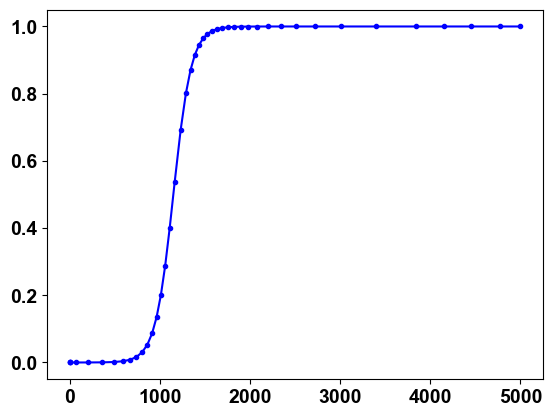

In [311]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt


def logistic(t, y, r):
    return r * y * (1.0 - y)

r = .01
t0 = 0
y0 = 1e-5
t1 = 5000.0

backend = 'dopri5'
# backend = 'dop853'
solver = ode(logistic, jac=None).set_integrator('dopri5',method='adams', atol=10**-6, rtol=10**-6,nsteps=1e8)

sol = []
def solout(t, y):
    sol.append([t, *y])
solver.set_solout(solout)
solver.set_initial_value(y0, t0).set_f_params(r)
solver.integrate(t1)

sol = np.array(sol)
plt.plot(sol[:,0], sol[:,1], 'b.-')
plt.show()

In [312]:
sol[:,0]

array([0.00000000e+00, 6.30959868e-01, 6.94055855e+00, 7.00365454e+01,
       2.06318519e+02, 3.63271611e+02, 4.95177063e+02, 5.94659100e+02,
       6.74203063e+02, 7.41275657e+02, 8.05590850e+02, 8.63360277e+02,
       9.16380519e+02, 9.65832304e+02, 1.01343953e+03, 1.06102844e+03,
       1.11081431e+03, 1.16605588e+03, 1.23249767e+03, 1.29089526e+03,
       1.34154498e+03, 1.38928817e+03, 1.43558302e+03, 1.48196362e+03,
       1.52956317e+03, 1.57940137e+03, 1.63240602e+03, 1.68953706e+03,
       1.75185458e+03, 1.82061843e+03, 1.89740185e+03, 1.98425979e+03,
       2.08398403e+03, 2.20052148e+03, 2.33969416e+03, 2.51050439e+03,
       2.72755007e+03, 3.01467524e+03, 3.39819882e+03, 3.83673831e+03,
       4.14893782e+03, 4.45623695e+03, 4.77894446e+03, 5.00000000e+03])

In [307]:
 sol[:,1]

array([1.00000000e-05, 1.00064330e-05, 1.00709912e-05, 1.07399303e-05,
       1.23079964e-05, 1.45571433e-05, 1.78089214e-05, 2.21268819e-05,
       2.77886236e-05, 3.50817409e-05, 4.44223797e-05, 5.63323835e-05,
       7.14885335e-05, 9.07517926e-05, 1.15219861e-04, 1.46287887e-04,
       1.85728638e-04, 2.35793281e-04, 2.99339997e-04, 3.79997135e-04,
       4.82370495e-04, 6.12306519e-04, 7.77226495e-04, 9.86550946e-04,
       1.25223861e-03, 1.58947105e-03, 2.01752235e-03, 2.56086435e-03,
       3.25057152e-03, 4.12610760e-03, 5.23759871e-03, 6.64872762e-03,
       8.44042173e-03, 1.07155574e-02, 1.36049690e-02, 1.72751364e-02,
       2.19380407e-02, 2.78638308e-02, 3.53971519e-02, 4.49782695e-02,
       5.71705045e-02, 7.26960055e-02, 9.24825186e-02, 1.17724454e-01,
       1.49961613e-01, 1.91176302e-01, 2.43897081e-01, 3.11255245e-01,
       3.96853131e-01, 5.04680259e-01, 6.54592823e-01, 7.59014363e-01,
       8.34839836e-01, 8.84930452e-01, 9.20542661e-01, 9.45306598e-01,
      

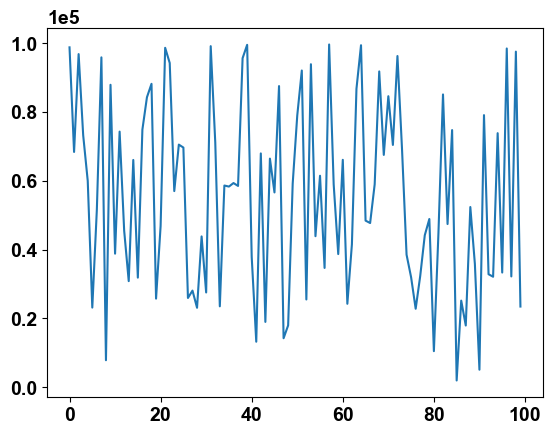

array([98769.5830308 , 68372.28368658, 96809.82207702, 73242.33811917,
       59967.93568902, 23145.70655483, 51588.98388045, 95860.13699436,
        7844.03245124, 87890.51033711, 38813.07696917, 74285.89185907,
       45491.67832087, 30831.26946591, 66046.74546387, 31849.80493946,
       74861.04016039, 84268.89038189, 88174.07636057, 25746.52438087,
       46858.10555743, 98633.07586179, 94221.72622116, 56997.62826683,
       70506.29937564, 69649.55529494, 25937.50704529, 28079.64952188,
       23093.31280375, 43825.89267407, 27535.37956152, 99116.43915293,
       71116.38557817, 23510.63988321, 58618.63108418, 58308.33721266,
       59337.01792138, 58498.70420925, 95624.22680618, 99505.84614351,
       37881.20725696, 13225.25044145, 67946.9580153 , 18982.24734476,
       66435.18971576, 56607.54673983, 87518.18233886, 14233.14359836,
       17972.5378888 , 59169.47724179, 78956.31399206, 92042.31985551,
       25502.58140274, 93866.56958323, 43889.4292864 , 61456.99102751,
      

In [172]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(100)
y = np.random.random(100) * 1e5

fig, ax = plt.subplots()
ax.plot(x, y)
ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.show()
y

In [ ]:
array([ 5.01461747e-05+0.j, -7.45449368e-05+0.j,  2.77266301e-04+0.j,
        1.65569837e-04+0.j,  3.21059652e-04+0.j, -2.86118009e-04+0.j,
        6.00213323e-04+0.j, -9.72977612e-04+0.j, -1.14860916e-03+0.j,
       -5.46941280e-04+0.j,  1.60489964e-04+0.j,  7.01317857e-05+0.j,
        3.50875003e-05+0.j,  3.39921589e-05+0.j, -1.49797771e-04+0.j,
       -2.07620128e-05+0.j, -1.47271314e-04+0.j, -2.12584110e-04+0.j,
        4.54179242e-06+0.j,  5.13892806e-07+0.j])

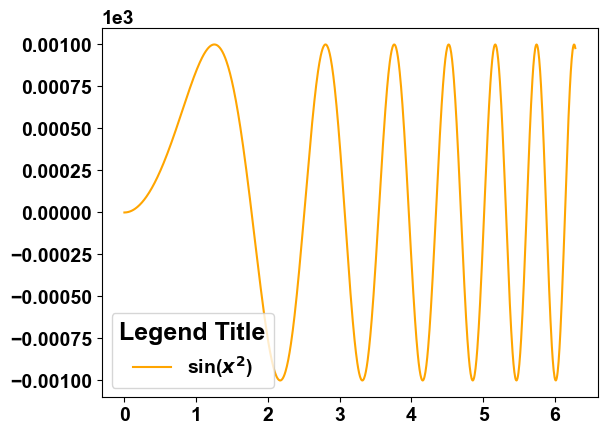

In [179]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 1000)
ax.plot(x, np.sin(x**2), 'orange', label=r'sin($x^2$)')
ax.legend(title='Legend Title', fontsize=14, title_fontsize=18)
ax.ticklabel_format(style='sci', scilimits=(3, 3), axis='y')

In [176]:
np.sin(x**2)/1e3

array([ 0.00000000e+00,  3.95574930e-08,  1.58229971e-07,  3.56017430e-07,
        6.32919846e-07,  9.88937165e-07,  1.42406927e-06,  1.93831594e-06,
        2.53167685e-06,  3.20415145e-06,  3.95573899e-06,  4.78643838e-06,
        5.69624819e-06,  6.68516653e-06,  7.75319096e-06,  8.90031842e-06,
        1.01265451e-05,  1.14318665e-05,  1.28162769e-05,  1.42797696e-05,
        1.58223370e-05,  1.74439696e-05,  1.91446570e-05,  2.09243866e-05,
        2.27831445e-05,  2.47209145e-05,  2.67376785e-05,  2.88334157e-05,
        3.10081033e-05,  3.32617154e-05,  3.55942234e-05,  3.80055955e-05,
        4.04957964e-05,  4.30647876e-05,  4.57125265e-05,  4.84389666e-05,
        5.12440570e-05,  5.41277424e-05,  5.70899625e-05,  6.01306521e-05,
        6.32497407e-05,  6.64471519e-05,  6.97228036e-05,  7.30766073e-05,
        7.65084682e-05,  8.00182846e-05,  8.36059473e-05,  8.72713401e-05,
        9.10143387e-05,  9.48348107e-05,  9.87326151e-05,  1.02707602e-04,
        1.06759613e-04,  

In [177]:
.00025*1e3

0.25